In [1]:
import os
import random

import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage
from PIL import Image
import cv2

from utils import LabelNormalize, DeNormalize

/home/ma-user/anaconda3/envs/PyTorch-1.11.0/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


### Dataset定义
数据集与上次实验中使用AlexNet预测密度图的数据集一致。

注意：这里图像和密度图的尺寸并未保持一致。出于对模型在云平台上稳定训练的考虑，下面的模型部分没有使用upsample操作，故应在数据载入时进行相应处理，保证模型输出尺寸与密度图尺寸一致。具体地，密度图下采样为原尺寸的1/8，同时乘64（8*8）以保持总人数不变。

In [2]:
class SHHB(Dataset):
    def __init__(self, data_path, mode='train', main_transform=None, img_transform=None, gt_transform=None):
        self.img_path = data_path + '/' + mode + '_data/img'
        self.gt_path = data_path + '/' + mode + '_data/den'
        self.data_files = [filename for filename in os.listdir(self.img_path) \
                           if os.path.isfile(os.path.join(self.img_path,filename))]
        self.num_samples = len(self.data_files) 
        self.main_transform=main_transform  
        self.img_transform = img_transform
        self.gt_transform = gt_transform     
    
    def __getitem__(self, index):
        fname = self.data_files[index]
        img, den = self._read_image_and_gt(fname)
        if self.main_transform is not None:
            img, den = self.main_transform(img, den) 
        if self.img_transform is not None:
            img = self.img_transform(img)         
        if self.gt_transform is not None:
            den = self.gt_transform(den)               
        return img, den

    def __len__(self):
        return self.num_samples

    def _read_image_and_gt(self, fname):
        img = Image.open(os.path.join(self.img_path, fname))
        if img.mode == 'L':
            img = img.convert('RGB')
        den = pd.read_csv(os.path.join(self.gt_path, os.path.splitext(fname)[0] + '.csv'), sep=',', header=None).values
        den = den.astype(np.float32, copy=False)    
        den = cv2.resize(den, (den.shape[1] // 8, den.shape[0] // 8), interpolation=cv2.INTER_CUBIC) * 64
        return img, den

    def get_num_samples(self):
        return self.num_samples

### 实现训练、验证和测试所用的DataLoader

与Alex实验代码相比，这里没有使用随机裁剪和反转来增强训练数据。

In [3]:
def get_data_loader(dataset_path, batch_size=8, mode='train'):
    assert mode == 'train' or mode == 'test'
    mean_std = ([0.485, 0.456, 0.406], 
                [0.229, 0.224, 0.225])
    log_para = 100
    img_transform = Compose([
        ToTensor(),
        Normalize(*mean_std)
    ])
    gt_transform = Compose([
        LabelNormalize(log_para)
    ])
    restore_transform = Compose([
        DeNormalize(*mean_std),
        ToPILImage()
    ])
    main_transform = None
    dataset = None
    data_loader = None
    if mode == 'train':
        dataset = SHHB(dataset_path, 
                    'train', 
                    main_transform=main_transform, 
                    img_transform=img_transform, 
                    gt_transform=gt_transform)
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        train_data_loader = DataLoader(train_dataset, 
                                batch_size=batch_size, 
                                num_workers=8, 
                                shuffle=True, 
                                drop_last=True)
        val_data_loader = DataLoader(val_dataset, 
                                batch_size=batch_size, 
                                num_workers=8, 
                                shuffle=True, 
                                drop_last=True)
        return train_data_loader, val_data_loader, log_para, restore_transform
    elif mode == 'test':
        main_transform = None
        dataset = SHHB(dataset_path, 
                    'test', 
                    main_transform=main_transform, 
                    img_transform=img_transform, 
                    gt_transform=gt_transform)
        data_loader = DataLoader(dataset, 
                                batch_size=batch_size, 
                                num_workers=8, 
                                shuffle=True, 
                                drop_last=True)
        return data_loader, log_para, restore_transform

### DataLoader验证

密度图尺寸为原图像尺寸1/8，符合预期。

In [4]:
chk_train_loader, chk_val_loader, _, _ = get_data_loader('./dataset', 4, 'train')
train_img, train_gt = next(iter(chk_train_loader))
print(train_img.shape, train_gt.shape)
val_img, val_gt = next(iter(chk_val_loader))
print(val_img.shape, val_gt.shape)
chk_test_loader, _, _ = get_data_loader('./dataset', 1, 'test')
test_img, test_gt  = next(iter(chk_test_loader))
print(test_img.shape, test_gt.shape)

torch.Size([4, 3, 768, 1024]) torch.Size([4, 96, 128])
torch.Size([4, 3, 768, 1024]) torch.Size([4, 96, 128])
torch.Size([1, 3, 768, 1024]) torch.Size([1, 96, 128])


**任务. 实现 CSRNet 类中的 _make_layers 方法，使用_make_layers 方法补全模型的 frontend 和 backend 部分以及前向传播流程。**

**具体要求：**

_make_layers 方法根据提供的配置列表创建神经网络的一系列层。这个配置列表 cfg 包含整数和字符 'M'：整数代表需要创建的卷积层的输出通道数，而 'M' 代表一个最大池化层。此方法还应能够处理可选参数，以支持不同的网络配置需求，包括输入通道数 in_channels，是否使用批量归一化 batch_norm，以及是否应用空洞卷积 dilation。

forward 方法即一般的前向传播。

另外，本次实验的预训练权重是从当前所在目录读取的，注意从OBS中上传至当前目录。

**_make_layers 方法实现提示：**
1. 初始化层列表： 开始时，创建一个空列表 layers 以收集所有生成的层。
2. 遍历配置列表： 对 cfg 进行遍历，根据遍历到的元素类型（整数或 'M'）来决定添加什么类型的层。
3. 卷积层： 如果元素是整数，你需要添加一个 nn.Conv2d 层。该层的输入通道数为 in_channels（这个值会随着新层的添加而更新），输出通道数为当前元素值。确保考虑 dilation 参数，如果 dilation 为 True，则应该使用不同的 dilation 和 padding 值来创建卷积层。
4. 最大池化层： 如果元素是 'M'，则添加一个 nn.MaxPool2d 层，通常使用 2x2 的池化窗口和步长。
5. 批量归一化和激活： 对于每个卷积层，根据 batch_norm 参数决定是否添加 nn.BatchNorm2d 层。不论是否使用批量归一化，都应该在每个卷积层后添加 nn.ReLU 作为激活函数。
6. 更新输入通道数： 每添加一个卷积层后，更新 in_channels 的值为该层的输出通道数，以便为下一个卷积层正确设置输入通道数。
7. 返回层序列： 使用 nn.Sequential 将列表 layers 中的所有层转换成一个序列，并返回这个序列。
8. 关于模型配置细节，可以参考CSRNet论文Table3。


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512, 256, 128, 64]
        self.frontend = self._make_layers(self.frontend_feat)
        self.backend = self._make_layers(self.backend_feat, in_channels=512, dilation=True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        mod = models.vgg16(pretrained=False)
        mod.load_state_dict(torch.load('./vgg16-397923af.pth'))
        self.frontend.load_state_dict(mod.features[0:23].state_dict())

    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x 
    
    def _make_layers(self, cfg, in_channels=3, batch_norm=False, dilation=False):
        if dilation:
            d_rate = 2
        else:
            d_rate = 1
        layers = []
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU()]
                else:
                    layers += [conv2d, nn.ReLU()]
                in_channels = v
        return nn.Sequential(*layers)

### 模型验证

In [6]:
model = CSRNet()
ret = model(torch.randn(4, 3, 64, 64))
print(ret.shape)

torch.Size([4, 1, 8, 8])


In [7]:
def train(net, train_loader, device, criterion, optimizer, epoch):
    net.train()
    total_loss = 0
    for inputs, gt in train_loader:
        inputs, gt = inputs.to(device), gt.to(device)
        pred_map = net(inputs).squeeze()
        optimizer.zero_grad()
        loss = criterion(pred_map, gt)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    return avg_loss

def val(net, val_loader, device, criterion, epoch, log_para):
    net.eval()
    total_loss = 0
    gt_cnt_lis = []
    pred_cnt_lis = []
    with torch.no_grad():
        for inputs, gt in val_loader:
            inputs, gt = inputs.to(device), gt.to(device)
            pred_map = net(inputs).squeeze()

            loss = criterion(pred_map, gt)
            total_loss += loss.item()
            gt = gt.data.cpu().numpy()
            pred_map = pred_map.data.cpu().numpy()
            for i in range(gt.shape[0]):
                gt_cnt = np.sum(gt[i]) / log_para
                pred_cnt = np.sum(pred_map[i]) / log_para
                gt_cnt_lis.append(float(gt_cnt))
                pred_cnt_lis.append(float(pred_cnt))

    avg_loss = total_loss / len(val_loader)
    y_true = np.array(gt_cnt_lis)
    y_pred = np.array(pred_cnt_lis)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2)) 
    mae = np.mean(np.abs(y_true - y_pred))
    return avg_loss, rmse, mae

### 昇腾迁移

In [8]:
import torch_npu
print(torch.cuda.is_available())

from torch_npu.contrib import transfer_to_npu
print(torch.cuda.is_available())
print(torch.npu.is_available())

False
True
True


/home/ma-user/anaconda3/envs/PyTorch-1.11.0/lib/python3.7/site-packages/torch_npu/contrib/transfer_to_npu.py:167: ImportWarning: 
    *************************************************************************************************************
    The torch.Tensor.cuda and torch.nn.Module.cuda are replaced with torch.Tensor.npu and torch.nn.Module.npu now..
    The torch.cuda.DoubleTensor is replaced with torch.npu.FloatTensor cause the double type is not supported now..
    The backend in torch.distributed.init_process_group set to hccl now..
    The torch.cuda.* and torch.cuda.amp.* are replaced with torch.npu.* and torch.npu.amp.* now..
    The device parameters have been replaced with npu in the function below:
    torch.logspace, torch.randint, torch.hann_window, torch.rand, torch.full_like, torch.ones_like, torch.rand_like, torch.randperm, torch.arange, torch.frombuffer, torch.normal, torch._empty_per_channel_affine_quantized, torch.empty_strided, torch.empty_like, torch.scalar_t

### 模型训练

In [9]:
%%time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, val_loader, log_para, _ = get_data_loader('./dataset', batch_size=8, mode='train')
net = CSRNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-5, momentum=0.95, weight_decay=5e-4)

# 可适当减小训练轮数，根据经验来说，200轮上下即可得到相对不错的结果
num_epochs = 400
for epoch in range(num_epochs):
    best_val_rmse = np.inf
    best_val_mae = np.inf
    train_loss = train(net, train_loader, device, criterion, optimizer, epoch)
    val_loss, val_rmse, val_mae = val(net, val_loader, device, criterion, epoch, log_para)
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, \
          Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}')
    if val_rmse < best_val_rmse or val_mae < best_val_mae:
        best_val_rmse = np.min([best_val_rmse, val_rmse])
        best_val_mae = np.min([best_val_mae, val_mae])
        torch.save(net.state_dict(), f'{net.__class__.__name__}_best_model.pth')

Epoch 1, Train Loss: 54.8156, Val Loss: 56.0610,           Val RMSE: 166.4308, Val MAE: 137.7492
Epoch 2, Train Loss: 54.7776, Val Loss: 56.0163,           Val RMSE: 164.4186, Val MAE: 135.3175
Epoch 3, Train Loss: 54.7343, Val Loss: 55.9718,           Val RMSE: 162.3902, Val MAE: 132.8519
Epoch 4, Train Loss: 54.6925, Val Loss: 55.9286,           Val RMSE: 160.3998, Val MAE: 130.4183
Epoch 5, Train Loss: 54.6522, Val Loss: 55.8870,           Val RMSE: 158.4626, Val MAE: 128.0358
Epoch 6, Train Loss: 54.6136, Val Loss: 55.8462,           Val RMSE: 156.5414, Val MAE: 125.6591
Epoch 7, Train Loss: 54.5750, Val Loss: 55.8080,           Val RMSE: 154.7307, Val MAE: 123.4060
Epoch 8, Train Loss: 54.5394, Val Loss: 55.7678,           Val RMSE: 152.8089, Val MAE: 120.9999
Epoch 9, Train Loss: 54.5022, Val Loss: 55.7301,           Val RMSE: 150.9932, Val MAE: 118.7129
Epoch 10, Train Loss: 54.4665, Val Loss: 55.6921,           Val RMSE: 149.1523, Val MAE: 116.3800
Epoch 11, Train Loss: 54.4306

In [10]:
import matplotlib.pyplot as plt

def visualize_density_map(pred_maps, gts, idx):
    n = pred_maps.shape[0]
    _, axes = plt.subplots(n, 3, figsize=(15, 5 * n))

    for i in range(n):
        pred_map = pred_maps[i]
        gt = gts[i]
        pred_map = (pred_map - np.min(pred_map)) / (np.max(pred_map) - np.min(pred_map))
        gt = (gt - np.min(gt)) / (np.max(gt) - np.min(gt))
        diff = pred_map - gt
        axes[i, 0].imshow(pred_map, cmap='jet', interpolation='nearest')
        axes[i, 0].set_title(f'Density Map Prediction')
        axes[i, 1].imshow(gt, cmap='jet', interpolation='nearest')
        axes[i, 1].set_title(f'Density Map Ground Truth')
        axes[i, 2].imshow(diff, cmap='jet', interpolation='nearest')
        axes[i, 2].set_title(f'Difference')

    plt.tight_layout()
    plt.show()

def test(net, test_loader, device, log_para):
    net.eval()
    gt_cnt_lis = []
    pred_cnt_lis = []
    visual_iter_idx_lis = [0]
    with torch.no_grad():
        for idx, (inputs, gt) in enumerate(test_loader):
            inputs, gt = inputs.to(device), gt.to(device)
            pred_map = net(inputs).squeeze()

            gt = gt.data.cpu().numpy()
            pred_map = pred_map.data.cpu().numpy()
            if idx in visual_iter_idx_lis:
                visualize_density_map(pred_map, gt, idx)
            for i in range(gt.shape[0]):
                gt_cnt = np.sum(gt[i]) / log_para
                pred_cnt = np.sum(pred_map[i]) / log_para
                gt_cnt_lis.append(float(gt_cnt))
                pred_cnt_lis.append(float(pred_cnt))

    y_true = np.array(gt_cnt_lis)
    y_pred = np.array(pred_cnt_lis)
    rmse = np.sqrt(np.mean((y_true - y_pred)**2)) 
    mae = np.mean(np.abs(y_true - y_pred))
    return rmse, mae

### 模型测试

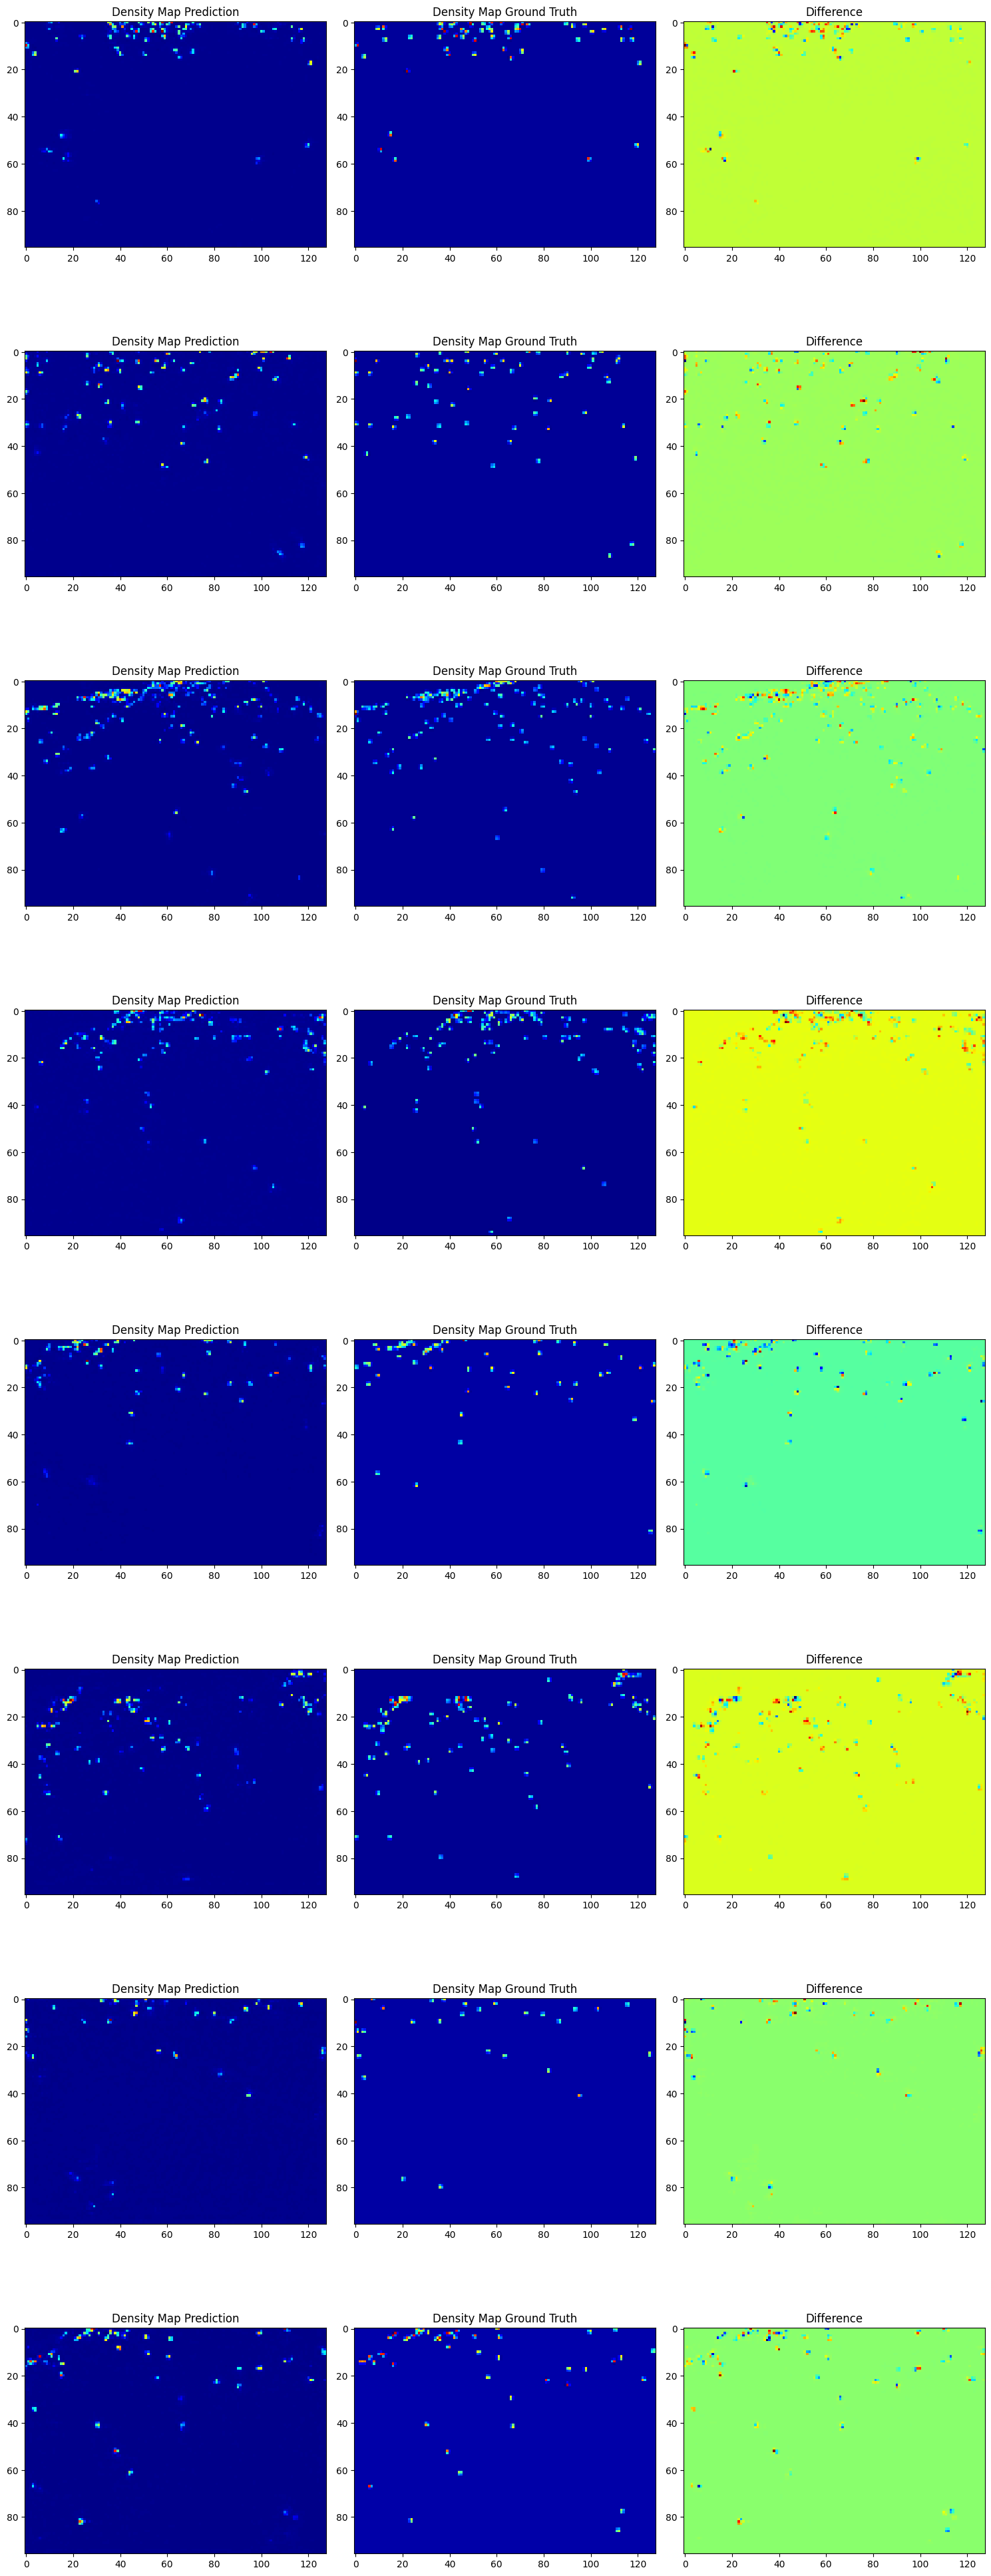

Test RMSE: 17.8763, Test MAE: 11.9340


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = CSRNet().to(device)
net.load_state_dict(torch.load(f'{net.__class__.__name__}_best_model.pth'))
test_loader, log_para, restore_transform = get_data_loader('./dataset', batch_size=8, mode='test')
test_rmse, test_mae = test(net, test_loader, device, log_para)
print(f'Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}')
